In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt

In [40]:
os.chdir("/Users/shubhgoela/Documents/MSc Quant Fin")

In [3]:
options_expiry = '10/17/25'
r = 0.041  # risk-free rate # same as used by etga for arbitradge calculations
q = 0.012  # dividend yield
options_data = {}

In [4]:
datetime.strptime(options_expiry, '%m/%d/%y').date().month

10

In [5]:
closing_prices = pd.read_excel('closing_prices.xlsx', engine='openpyxl', parse_dates=['Date'])
closing_prices['Date'] = closing_prices['Date'].dt.date
closing_prices.sort_values(by='Date',inplace=True)
closing_prices.reset_index(drop=True, inplace=True)
closing_prices['percent_change'] = closing_prices['Last Price'].pct_change()
closing_prices['log_return'] = np.log(closing_prices['Last Price'] / closing_prices['Last Price'].shift(1))
closing_prices['stdev_22'] = closing_prices['percent_change'].rolling(window=22).std()
closing_prices['stdev_22_annualized'] = closing_prices['stdev_22'] * np.sqrt(252)
closing_prices['stdev_22_ln'] = closing_prices['log_return'].rolling(window=22).std()
closing_prices['stdev_22_ln_annualized'] = closing_prices['stdev_22_ln'] * np.sqrt(252)

/var/folders/pr/5qrnbjyd35g7js8x5y3q4g300000gn/T/ipykernel_34431/4271629502.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  closing_prices['percent_change'] = closing_prices['Last Price'].pct_change()


In [6]:
closing_prices.head()

,Date,Last Price,Volume,SMAVG (15),percent_change,log_return,stdev_22,stdev_22_annualized,stdev_22_ln,stdev_22_ln_annualized
0,2020-10-19,87.56,7994502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-10-20,88.26,7358557,NaN,0.007995,0.007963,NaN,NaN,NaN,NaN
2,2020-10-21,87.64,7387647,NaN,-0.007025,-0.007049,NaN,NaN,NaN,NaN
3,2020-10-22,88.21,5659769,NaN,0.006504,0.006483,NaN,NaN,NaN,NaN
4,2020-10-23,88.31,4165381,NaN,0.001134,0.001133,NaN,NaN,NaN,NaN


In [7]:
def process_options_data(file_path, expiry_date):
    """
    Reads options data from Excel and returns separate dataframes for calls and puts.
    
    Parameters:
    -----------
    file_path : str
        Path to the Excel file containing options data
    expiry_date : str
        Expiry date string to filter (e.g., "10/17/25")
        
    Returns:
    --------
    tuple of (calls_df, puts_df)
        Two dataframes containing Strike, Bid, Ask, and Mid columns
    """
    
    # Read the Excel file using openpyxl engine explicitly
    df = pd.read_excel(file_path, engine='openpyxl')
    
    # Split the dataframe into calls and puts sections
    num_cols = len(df.columns)
    mid_point = num_cols // 2

    # Extract calls data (first set of columns)
    calls_cols = df.columns[:mid_point]
    calls_df = df[calls_cols].copy()
    calls_df.columns = ['Ticker', 'Strike', 'Bid', 'Ask', 'Last', 'IVM', 'Volm']
    
    # Extract puts data (second set of columns)
    puts_cols = df.columns[mid_point:]
    puts_df = df[puts_cols].copy()
    puts_df.columns = ['Ticker', 'Strike', 'Bid', 'Ask', 'Last', 'IVM', 'Volm']
    
    # Filter based on expiry date in Ticker
    calls_df = calls_df[calls_df['Ticker'].astype(str).str.contains(expiry_date, na=False)]
    puts_df = puts_df[puts_df['Ticker'].astype(str).str.contains(expiry_date, na=False)]
    
    # Calculate Mid price (average of Bid and Ask)
    calls_df['Mid'] = (calls_df['Bid'] + calls_df['Ask']) / 2
    puts_df['Mid'] = (puts_df['Bid'] + puts_df['Ask']) / 2
    
    # Select only required columns
    # output_cols = ['Strike', 'Bid', 'Ask', 'Mid']
    # calls_result = calls_df[output_cols].reset_index(drop=True)
    # puts_result = puts_df[output_cols].reset_index(drop=True)

    calls_result = calls_df.reset_index(drop=True)
    puts_result = puts_df.reset_index(drop=True)
    
    #  Calculate Spread
    calls_result['Spread'] = calls_result['Ask'] - calls_result['Bid']
    puts_result['Spread'] = puts_result['Ask'] - puts_result['Bid']
    
    return calls_result, puts_result


# Function 2: Multiple files, single expiry
def process_multiple_files_single_expiry(file_paths, expiry_date):
    """
    Processes multiple Excel files for the same expiry date.
    
    Parameters:
    -----------
    file_paths : list of str
        List of paths to Excel files
    expiry_date : str
        Single expiry date to filter (e.g., "10/17/25")
        
    Returns:
    --------
    dict
        Dictionary with file names as keys and tuples of (calls_df, puts_df) as values
    """
    
    results = {}
    
    for file_path in file_paths:
        try:
            # Get filename for the key
            file_name = os.path.basename(file_path).split('.')[0]
            
            # Process the file
            calls, puts = process_options_data(file_path, expiry_date)
            
            # print(f"\nProcessing {file_name}...")
            # print('calls: ')
            # print(calls.head())
            # print('puts: ')
            # print(puts.head())
            results[file_name] = { "calls" : calls, "puts": puts }
            print(f"✓ Processed {file_name}: {len(calls)} calls, {len(puts)} puts")
            
        except Exception as e:
            print(f"✗ Error processing {file_path}: {str(e)}")
            results[file_name] = (None, None)
    
    return results


# Function 3: Multiple files, multiple expiries
def process_multiple_files_multiple_expiries(file_paths, expiry_dates_list):
    """
    Processes multiple Excel files for multiple expiry dates.
    
    Parameters:
    -----------
    file_paths : list of str
        List of paths to Excel files
    expiry_dates_list : list of str
        List of expiry dates to filter (e.g., ["10/17/25", "11/21/25"])
        
    Returns:
    --------
    dict
        Nested dictionary: {file_name: {expiry_date: (calls_df, puts_df)}}
    """
    
    results = {}
    
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        results[file_name] = {}
        
        print(f"\nProcessing {file_name}...")
        
        for expiry_date in expiry_dates_list:
            try:
                calls, puts = process_options_data(file_path, expiry_date)
                results[file_name][expiry_date] = (calls, puts)
                print(f"  ✓ {expiry_date}: {len(calls)} calls, {len(puts)} puts")
                
            except Exception as e:
                print(f"  ✗ {expiry_date}: Error - {str(e)}")
                results[file_name][expiry_date] = (None, None)
    
    return results


# Function 4: Process all files in a folder
def process_files_in_folder(folder_path, expiry_date, file_pattern='*.xlsx'):
    """
    Processes all Excel files in a folder for a single expiry date.
    
    Parameters:
    -----------
    folder_path : str
        Path to folder containing Excel files
    expiry_date : str
        Single expiry date to filter (e.g., "10/17/25")
    file_pattern : str
        Pattern to match files (default: '*.xlsx')
        
    Returns:
    --------
    dict
        Dictionary with file names as keys and tuples of (calls_df, puts_df) as values
    """
    import glob
    
    # Get all Excel files in folder
    pattern = os.path.join(folder_path, file_pattern)
    file_paths = glob.glob(pattern)
    
    print(f"Found {len(file_paths)} Excel files in {folder_path}")
    
    return process_multiple_files_single_expiry(file_paths, expiry_date)


In [8]:
options_data = process_files_in_folder('', '10/17/25')
print(options_data.keys())
# del options_data['~$closing_prices']
del options_data['closing_prices']

Found 22 Excel files in 
✓ Processed 3_Oct: 78 calls, 78 puts
✓ Processed 2_Oct: 78 calls, 78 puts
✓ Processed 10_Oct: 96 calls, 96 puts
✓ Processed 9_Oct: 95 calls, 95 puts
✓ Processed 8_Oct: 95 calls, 95 puts
✓ Processed 26_Sep: 78 calls, 78 puts
✓ Processed 19_Sep: 41 calls, 41 puts
✓ Processed 16_Oct: 96 calls, 96 puts
✓ Processed 17_Oct: 96 calls, 96 puts
✗ Error processing closing_prices.xlsx: Length mismatch: Expected axis has 2 elements, new values have 7 elements
✓ Processed 30_Sep: 78 calls, 78 puts
✓ Processed 13_Oct: 96 calls, 96 puts
✓ Processed 29_Sep: 78 calls, 78 puts
✓ Processed 1_Oct: 78 calls, 78 puts
✓ Processed 22_Sep: 61 calls, 61 puts
✓ Processed 23_Sep: 61 calls, 61 puts
✓ Processed 15_Oct: 96 calls, 96 puts
✓ Processed 14_Oct: 96 calls, 96 puts
✓ Processed 7_Oct: 84 calls, 84 puts
✓ Processed 6_Oct: 84 calls, 84 puts
✓ Processed 25_Sep: 78 calls, 78 puts
✓ Processed 24_Sep: 76 calls, 76 puts
dict_keys(['3_Oct', '2_Oct', '10_Oct', '9_Oct', '8_Oct', '26_Sep', '19

In [9]:
options_data['3_Oct']['calls'].head()

,Ticker,Strike,Bid,Ask,Last,IVM,Volm,Mid,Spread
0,TSM 10/17/25 C70,70,221.350006,225,0,260.03479,0,223.175003,3.649994
1,TSM 10/17/25 C75,75,216.350006,220,0,244.414856,0,218.175003,3.649994
2,TSM 10/17/25 C80,80,211.399994,214.899994,0,213.641235,0,213.149994,3.5
3,TSM 10/17/25 C85,85,206.399994,208.899994,0,0,0,207.649994,2.5
4,TSM 10/17/25 C90,90,201.399994,205.449997,0,255.788681,0,203.424995,4.050003


In [10]:

def black_scholes_price(S, K, T, r, sigma, option_type='call', q=0.0):
    """
    Black-Scholes with dividend yield.
    
    Parameters:
    -----------
    S : float
        Current stock price
    K : float
        Strike price
    T : float
        Time to expiration in years
    r : float
        Risk-free rate
    sigma : float
        Volatility (standard deviation)
    option_type : str
        'call' or 'put'
    q : float
        Continuous dividend yield (annualized)
    """
    if T <= 0 or sigma <= 0:
        return 0
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    
    return price



def calculate_implied_volatility(market_price, S, K, T, r, option_type='call', q = 0.0,
                                  max_iterations=300, precision=1e-5):
    """
    Calculate implied volatility using Brent's method.
    
    Parameters:
    -----------
    market_price : float
        Market price of the option
    S : float
        Current stock price
    K : float
        Strike price
    T : float
        Time to expiration in years
    r : float
        Risk-free rate
    option_type : str
        'call' or 'put'
    max_iterations : int
        Maximum number of iterations
    precision : float
        Desired precision
        
    Returns:
    --------
    float
        Implied volatility (annualized)
    """
    if market_price <= 0 or T <= 0:
        return np.nan
    
    # Intrinsic value check
    if option_type == 'call':
        intrinsic = max(S - K, 0)
    else:
        intrinsic = max(K - S, 0)
    
    if market_price < intrinsic:
        return np.nan
    
    def objective(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type, q) - market_price
    
    try:
        # Try to find IV between 0.01% and 500%
        iv = brentq(objective, 0.0001, 5.0, maxiter=max_iterations, xtol=precision)
        return iv
    except:
        return np.nan


def add_implied_volatility(df, option_type, S, T, r=0.0, q = 0.0, price_column='Mid'):
    """
    Add implied volatility column to options dataframe.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Options dataframe with columns: Strike, Bid, Ask, Mid
    option_type : str
        'call' or 'put'
    S : float
        Current stock/underlying price
    T : float
        Time to expiration in years
    r : float
        Risk-free rate (default: 0.0)
    price_column : str
        Column to use for market price (default: 'Mid')
        
    Returns:
    --------
    pandas DataFrame
        Original dataframe with added 'IV' column (implied volatility in decimal form)
        and 'IV_Percent' column (implied volatility as percentage)
    """
    
    df = df.copy()
    
    # Calculate IV for each row
    ivs = []
    for idx, row in df.iterrows():
        K = row['Strike']
        market_price = row[price_column]
        
        iv = calculate_implied_volatility(
            market_price=market_price,
            S=S,
            K=K,
            T=T,
            r=r,
            q = q,
            option_type=option_type.lower()
        )
        ivs.append(iv)
    
    df['IV'] = ivs
    df['IV_Percent'] = df['IV'] * 100  # Convert to percentage
    
    return df


# Example wrapper function for convenience
def calculate_iv_for_calls_and_puts(calls_df, puts_df, S, T, r=0.0, q=0.0, price_column='Mid'):
    """
    Calculate implied volatility for both calls and puts dataframes.
    
    Parameters:
    -----------
    calls_df : pandas DataFrame
        Calls dataframe with columns: Strike, Bid, Ask, Mid
    puts_df : pandas DataFrame
        Puts dataframe with columns: Strike, Bid, Ask, Mid
    S : float
        Current stock/underlying price
    T : float
        Time to expiration in years
    r : float
        Risk-free rate (default: 0.0)
    price_column : str
        Column to use for market price (default: 'Mid')
        
    Returns:
    --------
    tuple of (calls_with_iv, puts_with_iv)
        Both dataframes with added IV and IV_Percent columns
    """
    
    calls_with_iv = add_implied_volatility(calls_df, 'call', S, T, r, q, price_column)
    puts_with_iv = add_implied_volatility(puts_df, 'put', S, T, r, q, price_column)
    
    return calls_with_iv, puts_with_iv

In [11]:
for key, val in options_data.items():
    print(f"File: {key}")
    print('Date:', datetime.strptime(f'{key}_2025', '%d_%b_%Y').date())
    calls_df = val['calls']
    puts_df = val['puts']
    S = closing_prices[closing_prices['Date'] == datetime.strptime(f'{key}_2025', '%d_%b_%Y').date()]['Last Price'].values[0]
    T = (datetime.strptime(options_expiry, '%m/%d/%y').date() - datetime.strptime(f'{key}_2025', '%d_%b_%Y').date()).days / 365.0
    print(f"Underlying Price (S): {S}, Time to Expiry (T): {T:.4f} years")
    calls_df, puts_df = calculate_iv_for_calls_and_puts(calls_df, puts_df, S=S, T=T, r=r, q=q, price_column='Mid')
    val['calls'] = calls_df
    val['puts'] = puts_df
    val['spot'] = S

File: 3_Oct
Date: 2025-10-03
Underlying Price (S): 292.19, Time to Expiry (T): 0.0384 years
File: 2_Oct
Date: 2025-10-02
Underlying Price (S): 288.11, Time to Expiry (T): 0.0411 years
File: 10_Oct
Date: 2025-10-10
Underlying Price (S): 280.66, Time to Expiry (T): 0.0192 years
File: 9_Oct
Date: 2025-10-09
Underlying Price (S): 299.88, Time to Expiry (T): 0.0219 years
File: 8_Oct
Date: 2025-10-08
Underlying Price (S): 304.52, Time to Expiry (T): 0.0247 years
File: 26_Sep
Date: 2025-09-26
Underlying Price (S): 273.36, Time to Expiry (T): 0.0575 years
File: 19_Sep
Date: 2025-09-19
Underlying Price (S): 264.87, Time to Expiry (T): 0.0767 years
File: 16_Oct
Date: 2025-10-16
Underlying Price (S): 299.84, Time to Expiry (T): 0.0027 years
File: 17_Oct
Date: 2025-10-17
Underlying Price (S): 295.08, Time to Expiry (T): 0.0000 years
File: 30_Sep
Date: 2025-09-30
Underlying Price (S): 279.29, Time to Expiry (T): 0.0466 years
File: 13_Oct
Date: 2025-10-13
Underlying Price (S): 302.89, Time to Expiry

In [12]:
print(options_data.keys())

dict_keys(['3_Oct', '2_Oct', '10_Oct', '9_Oct', '8_Oct', '26_Sep', '19_Sep', '16_Oct', '17_Oct', '30_Sep', '13_Oct', '29_Sep', '1_Oct', '22_Sep', '23_Sep', '15_Oct', '14_Oct', '7_Oct', '6_Oct', '25_Sep', '24_Sep'])


In [13]:
print(options_data['3_Oct'].keys())

dict_keys(['calls', 'puts', 'spot'])


In [14]:
print(options_data['3_Oct']['calls'].head())

             Ticker Strike         Bid         Ask Last         IVM Volm  \
0  TSM 10/17/25 C70     70  221.350006         225    0   260.03479    0   
1  TSM 10/17/25 C75     75  216.350006         220    0  244.414856    0   
2  TSM 10/17/25 C80     80  211.399994  214.899994    0  213.641235    0   
3  TSM 10/17/25 C85     85  206.399994  208.899994    0           0    0   
4  TSM 10/17/25 C90     90  201.399994  205.449997    0  255.788681    0   

          Mid    Spread        IV  IV_Percent  
0  223.175003  3.649994  3.773112  377.311194  
1  218.175003  3.649994  3.592357  359.235724  
2  213.149994       3.5  3.409806  340.980610  
3  207.649994       2.5  2.907212  290.721238  
4  203.424995  4.050003  3.243886  324.388624  


In [15]:
options_data['16_Oct']['puts'][options_data['16_Oct']['puts']['Strike'] == 260]

,Ticker,Strike,Bid,Ask,Last,IVM,Volm,Mid,Spread,IV,IV_Percent
42,TSM 10/17/25 P260,260,0.03,0.04,0.05,91.557289,448,0.035,0.01,1.101758,110.175836


In [16]:
# Let me investigate in-the-money call options that still produce NaN IV
# This is often due to extreme moneyness or convergence issues

def debug_itm_call_iv(S, K, market_price, T, r, option_type='call'):
    """
    Debug a single option to see why IV calculation fails.
    
    Parameters:
    -----------
    S : float
        Stock price
    K : float
        Strike price
    market_price : float
        Market price (Mid)
    T : float
        Time to expiry in years
    r : float
        Risk-free rate
    option_type : str
        'call' or 'put'
    """
    
    print("="*70)
    print("DEBUGGING OPTION IV CALCULATION")
    print("="*70)
    
    # Calculate intrinsic and time value
    if option_type == 'call':
        intrinsic = max(S - K, 0)
    else:
        intrinsic = max(K - S, 0)
    
    time_value = market_price - intrinsic
    
    print(f"\nInput Parameters:")
    print(f"  Stock Price (S): ${S:.2f}")
    print(f"  Strike (K): ${K:.2f}")
    print(f"  Market Price: ${market_price:.2f}")
    print(f"  Time to Expiry (T): {T:.4f} years ({T*365:.1f} days)")
    print(f"  Risk-free rate (r): {r:.4f} ({r*100:.2f}%)")
    print(f"  Option Type: {option_type}")
    
    print(f"\nValuation Check:")
    print(f"  Intrinsic Value: ${intrinsic:.2f}")
    print(f"  Time Value: ${time_value:.2f}")
    print(f"  Moneyness (S/K): {S/K:.4f}")
    
    if option_type == 'call':
        if S > K:
            print(f"  Status: IN-THE-MONEY (ITM)")
        elif abs(S - K) / S < 0.05:
            print(f"  Status: AT-THE-MONEY (ATM)")
        else:
            print(f"  Status: OUT-OF-THE-MONEY (OTM)")
    
    # Try different IV starting points
    print(f"\nTesting Black-Scholes prices at different volatilities:")
    test_vols = [0.10, 0.20, 0.30, 0.50, 1.00, 2.00]
    
    for vol in test_vols:
        bs_price = black_scholes_price(S, K, T, r, vol, option_type)
        diff = bs_price - market_price
        print(f"  σ = {vol:.2f} ({vol*100:.0f}%): BS Price = ${bs_price:.4f}, Diff = ${diff:.4f}")
    
    # Check if solution exists
    bs_low = black_scholes_price(S, K, T, r, 0.0001, option_type)
    bs_high = black_scholes_price(S, K, T, r, 5.0, option_type)
    
    print(f"\nConvergence Check:")
    print(f"  BS Price at σ=0.01%: ${bs_low:.4f}")
    print(f"  BS Price at σ=500%: ${bs_high:.4f}")
    print(f"  Market Price: ${market_price:.4f}")
    
    if market_price < bs_low:
        print(f"  ⚠️ PROBLEM: Market price is BELOW minimum theoretical price!")
        print(f"     This violates no-arbitrage conditions.")
    elif market_price > bs_high:
        print(f"  ⚠️ PROBLEM: Market price is ABOVE maximum theoretical price!")
        print(f"     IV would need to be > 500% (unrealistic).")
    else:
        print(f"  ✓ Solution should exist in [0.01%, 500%] range")
    
    # Check for deep ITM issues
    if option_type == 'call' and S/K > 1.2:
        print(f"\n⚠️ DEEP ITM CALL DETECTED (S/K = {S/K:.2f}):")
        print(f"  - Deep ITM options have very low Vega (sensitivity to volatility)")
        print(f"  - Small pricing errors cause large IV estimation errors")
        print(f"  - Consider using Bid instead of Mid for deep ITM options")
    
    # Vega check
    d1 = (np.log(S / K) + (r + 0.5 * 0.20**2) * T) / (0.20 * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    
    print(f"\nVega Analysis (at σ=20%):")
    print(f"  Vega: ${vega:.4f}")
    if vega < 0.01:
        print(f"  ⚠️ WARNING: Very low Vega! Small price changes = huge IV swings")
        print(f"  This option is not sensitive to volatility changes.")
    
    return None


def add_implied_volatility_robust(df, option_type, S, T, r=0.0, price_column='Mid', 
                                   use_bid_for_deep_itm=True, itm_threshold=1.15):
    """
    Enhanced IV calculation with special handling for deep ITM options.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Options dataframe
    option_type : str
        'call' or 'put'
    S : float
        Stock price
    T : float
        Time to expiry in years
    r : float
        Risk-free rate
    price_column : str
        Default price column to use
    use_bid_for_deep_itm : bool
        If True, use Bid price for deep ITM options (more conservative)
    itm_threshold : float
        Moneyness threshold to consider "deep ITM" (default 1.15 = 15% ITM)
    """
    
    df = df.copy()
    ivs = []
    price_used = []
    
    for idx, row in df.iterrows():
        K = row['Strike']
        
        # Determine which price to use
        if option_type.lower() == 'call':
            moneyness = S / K
            is_deep_itm = moneyness > itm_threshold
        else:
            moneyness = K / S
            is_deep_itm = moneyness > itm_threshold
        
        # Use Bid for deep ITM options (more conservative)
        if use_bid_for_deep_itm and is_deep_itm and not pd.isna(row['Bid']) and row['Bid'] > 0:
            market_price = row['Bid']
            price_source = 'Bid'
        else:
            market_price = row[price_column]
            price_source = price_column
        
        iv = calculate_implied_volatility(
            market_price=market_price,
            S=S,
            K=K,
            T=T,
            r=r,
            option_type=option_type.lower()
        )
        
        ivs.append(iv)
        price_used.append(price_source)
    
    df['IV'] = ivs
    df['IV_Percent'] = df['IV'] * 100
    df['Price_Used'] = price_used
    
    return df

In [17]:
# Pick one problematic ITM call and diagnose it
# Underlying Price (S): 264.87, Time to Expiry (T): 0.0767 years
debug_itm_call_iv(
    S=264.87,      # Current stock price
    K=110,       # Strike that's giving NaN
    market_price=154.925003,  # The Mid price
    T=0.0767,      # Time to expiry
    r=r,       # Risk-free rate
    option_type='call'
)


DEBUGGING OPTION IV CALCULATION

Input Parameters:
  Stock Price (S): $264.87
  Strike (K): $110.00
  Market Price: $154.93
  Time to Expiry (T): 0.0767 years (28.0 days)
  Risk-free rate (r): 0.0410 (4.10%)
  Option Type: call

Valuation Check:
  Intrinsic Value: $154.87
  Time Value: $0.06
  Moneyness (S/K): 2.4079
  Status: IN-THE-MONEY (ITM)

Testing Black-Scholes prices at different volatilities:
  σ = 0.10 (10%): BS Price = $155.2154, Diff = $0.2904
  σ = 0.20 (20%): BS Price = $155.2154, Diff = $0.2904
  σ = 0.30 (30%): BS Price = $155.2154, Diff = $0.2904
  σ = 0.50 (50%): BS Price = $155.2154, Diff = $0.2904
  σ = 1.00 (100%): BS Price = $155.2246, Diff = $0.2996
  σ = 2.00 (200%): BS Price = $157.3879, Diff = $2.4629

Convergence Check:
  BS Price at σ=0.01%: $155.2154
  BS Price at σ=500%: $188.1318
  Market Price: $154.9250
  ⚠️ PROBLEM: Market price is BELOW minimum theoretical price!
     This violates no-arbitrage conditions.

⚠️ DEEP ITM CALL DETECTED (S/K = 2.41):
  - 

In [18]:
# closing_prices['prev_close'] = closing_prices['Last Price'].shift(-1)
closing_prices.sort_values(by='Date').reset_index(drop=True)

,Date,Last Price,Volume,SMAVG (15),percent_change,log_return,stdev_22,stdev_22_annualized,stdev_22_ln,stdev_22_ln_annualized
0,2020-10-19,87.56,7994502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-10-20,88.26,7358557,NaN,0.007995,0.007963,NaN,NaN,NaN,NaN
2,2020-10-21,87.64,7387647,NaN,-0.007025,-0.007049,NaN,NaN,NaN,NaN
3,2020-10-22,88.21,5659769,NaN,0.006504,0.006483,NaN,NaN,NaN,NaN
4,2020-10-23,88.31,4165381,NaN,0.001134,0.001133,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1266,2025-11-03,304.86,12466592,14779121.0,0.014746,0.014638,0.028726,0.456017,0.028556,0.453309
1267,2025-11-04,294.05,16224285,14756216.0,-0.035459,-0.036103,0.029736,0.472037,0.029579,0.469550
1268,2025-11-05,293.64,10502502,14070515.0,-0.001394,-0.001395,0.028736,0.456165,0.028584,0.453756
1269,2025-11-06,289.24,11516858,13082208.0,-0.014984,-0.015098,0.028297,0.449208,0.028137,0.446654


In [19]:
closing_prices.sort_values(by='Date')['Last Price'].pct_change()

/var/folders/pr/5qrnbjyd35g7js8x5y3q4g300000gn/T/ipykernel_34431/1584226160.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  closing_prices.sort_values(by='Date')['Last Price'].pct_change()


0            NaN
1       0.007995
2      -0.007025
3       0.006504
4       0.001134
          ...   
1266    0.014746
1267   -0.035459
1268   -0.001394
1269   -0.014984
1270    0.000000
Name: Last Price, Length: 1271, dtype: float64

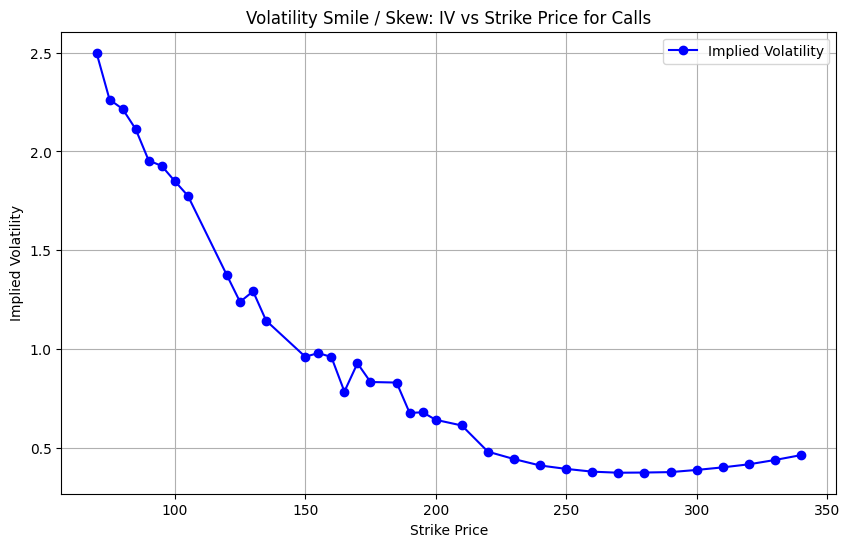

In [20]:
import matplotlib.pyplot as plt

df_clean = options_data['19_Sep']['calls'].dropna(subset=['IV'])
plt.figure(figsize=(10, 6))
plt.plot(df_clean['Strike'], df_clean['IV'], marker='o', linestyle='-', color='blue', label='Implied Volatility')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Volatility Smile / Skew: IV vs Strike Price for Calls')
plt.grid(True)
plt.legend()
plt.show()

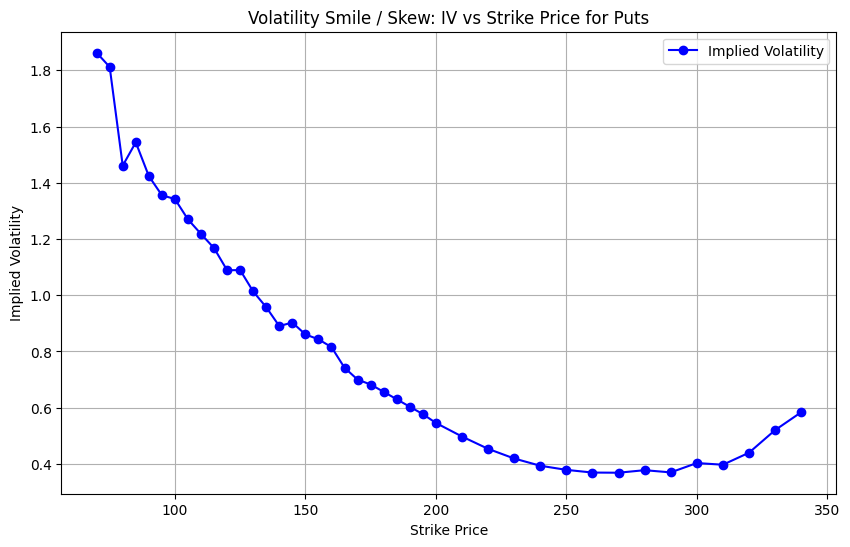

In [21]:
import matplotlib.pyplot as plt

df_clean = options_data['19_Sep']['puts'].dropna(subset=['IV'])
plt.figure(figsize=(10, 6))
plt.plot(df_clean['Strike'], df_clean['IV'], marker='o', linestyle='-', color='blue', label='Implied Volatility')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Volatility Smile / Skew: IV vs Strike Price for Puts')
plt.grid(True)
plt.legend()
plt.show()

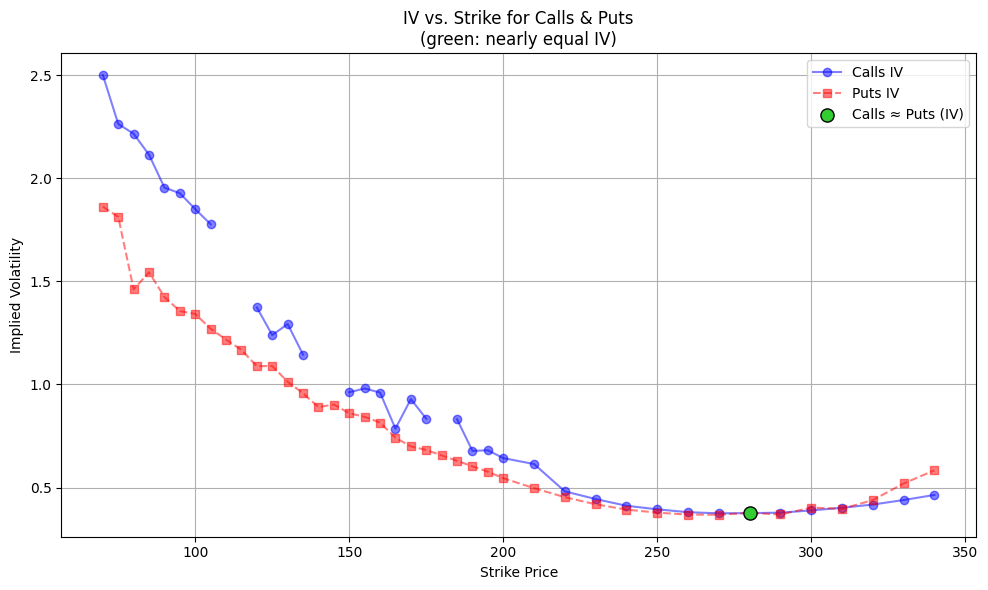

In [22]:
merged = pd.merge(
    options_data['19_Sep']['calls'][['Strike', 'IV']],
    options_data['19_Sep']['puts'][['Strike', 'IV']],
    on='Strike',
    suffixes=('_call', '_put')
)

# Define your approximation threshold (adjust as needed)
threshold = 0.005

# Identify nearly-equal IVs
merged['superimposed'] = np.abs(merged['IV_call'] - merged['IV_put']) < threshold

plt.figure(figsize=(10, 6))

# Calls and puts: all points
plt.plot(
    options_data['19_Sep']['calls']['Strike'], options_data['19_Sep']['calls']['IV'],
    marker='o', linestyle='-', color='blue', alpha=0.5, label='Calls IV'
)
plt.plot(
    options_data['19_Sep']['puts']['Strike'], options_data['19_Sep']['puts']['IV'],
    marker='s', linestyle='--', color='red', alpha=0.5, label='Puts IV'
)

# Highlight superimposed points
superimposed_strikes = merged[merged['superimposed']]['Strike']
superimposed_iv = merged[merged['superimposed']]['IV_call']  # (or IV_put, they're almost equal)

plt.scatter(
    superimposed_strikes, superimposed_iv,
    c='limegreen', edgecolor='black', s=90, zorder=3, label='Calls ≈ Puts (IV)'
)

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('IV vs. Strike for Calls & Puts\n(green: nearly equal IV)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [23]:
# Check your option chain dates
print("Available option expiration dates:")
dates = list(options_data.keys())
print(sorted(list(options_data.keys())))

# Check your stock price dates
print("\nStock price date range:")
print(f"From: {closing_prices['Date'].min()}")
print(f"To: {closing_prices['Date'].max()}")
print(f"Total days: {len(closing_prices)}")


Available option expiration dates:
['10_Oct', '13_Oct', '14_Oct', '15_Oct', '16_Oct', '17_Oct', '19_Sep', '1_Oct', '22_Sep', '23_Sep', '24_Sep', '25_Sep', '26_Sep', '29_Sep', '2_Oct', '30_Sep', '3_Oct', '6_Oct', '7_Oct', '8_Oct', '9_Oct']

Stock price date range:
From: 2020-10-19
To: 2025-11-07
Total days: 1271


In [42]:
import plotly.graph_objects as go
from scipy.interpolate import interp1d

# ============================================================================
# STEP 1: Parse Dates and Prepare Data
# ============================================================================

def parse_date_key(date_key, year=2025):
    day, month = date_key.split('_')
    date_str = f"{day} {month} {year}"
    return pd.to_datetime(date_str, format='%d %b %Y')

date_keys = list(options_data.keys())
parsed_dates = [(key, parse_date_key(key)) for key in date_keys]
parsed_dates.sort(key=lambda x: x[1])

sorted_date_keys = [item[0] for item in parsed_dates]
sorted_dates = [item[1] for item in parsed_dates]
expiry_date = sorted_dates[-1]

all_strikes_set = set()
for date_key in sorted_date_keys:
    calls = options_data[date_key]['calls'].dropna(subset=['IV'])
    all_strikes_set.update(calls['Strike'].values)

common_strikes = np.array(sorted(all_strikes_set))

closing_prices['Date'] = pd.to_datetime(closing_prices['Date'])

iv_calls_matrix = []
iv_puts_matrix = []
spot_prices = []
date_labels = []

for date_key, date in zip(sorted_date_keys, sorted_dates):
    calls = options_data[date_key]['calls'].copy()
    puts = options_data[date_key]['puts'].copy()
    
    calls_clean = calls.dropna(subset=['IV']).sort_values('Strike').reset_index(drop=True)
    puts_clean = puts.dropna(subset=['IV']).sort_values('Strike').reset_index(drop=True)
    
    if len(calls_clean) > 1:
        f_calls = interp1d(calls_clean['Strike'], calls_clean['IV'], 
                          kind='linear', bounds_error=False, fill_value='extrapolate')
        iv_calls_interp = f_calls(common_strikes)
    else:
        iv_calls_interp = np.full(len(common_strikes), np.nan)
    
    if len(puts_clean) > 1:
        f_puts = interp1d(puts_clean['Strike'], puts_clean['IV'], 
                         kind='linear', bounds_error=False, fill_value='extrapolate')
        iv_puts_interp = f_puts(common_strikes)
    else:
        iv_puts_interp = np.full(len(common_strikes), np.nan)
    
    iv_calls_matrix.append(iv_calls_interp)
    iv_puts_matrix.append(iv_puts_interp)
    
    spot_row = closing_prices[closing_prices['Date'] == date]
    if not spot_row.empty:
        spot = spot_row['Last Price'].values[0]
    else:
        idx = (closing_prices['Date'] - date).abs().idxmin()
        spot = closing_prices.loc[idx, 'Last Price']
    
    spot_prices.append(spot)
    date_labels.append(date.strftime('%b %d'))

Z_calls = np.array(iv_calls_matrix)
Z_puts = np.array(iv_puts_matrix)
spot_prices_array = np.array(spot_prices)

# Clean NaNs and clip negative IVs
Z_calls = pd.DataFrame(Z_calls).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
Z_puts = pd.DataFrame(Z_puts).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

# Clip to reasonable IV range
Z_calls = np.clip(Z_calls, 0.01, 5.0)
Z_puts = np.clip(Z_puts, 0.01, 5.0)

print(f"✓ Data prepared: {Z_calls.shape[0]} dates × {Z_calls.shape[1]} strikes")
print(f"Date range: {sorted_dates[0].strftime('%Y-%m-%d')} to {sorted_dates[-1].strftime('%Y-%m-%d')}")

# Convert dates to strings for Plotly (works better than datetime objects)
date_strings = [d.strftime('%Y-%m-%d') for d in sorted_dates]

# ============================================================================
# FIGURE 1: Call Surface with Dates
# ============================================================================

fig_calls = go.Figure()

fig_calls.add_trace(go.Surface(
    x=common_strikes,
    y=date_strings,  # Use date strings instead of days
    z=Z_calls,
    colorscale='Viridis',
    showscale=True,
    colorbar=dict(title="IV"),
    hovertemplate='<b>Strike:</b> $%{x:.2f}<br><b>Date:</b> %{y}<br><b>IV:</b> %{z:.2%}<extra></extra>'
))

fig_calls.update_layout(
    title='TSM Call Options - Volatility Surface',
    scene=dict(
        xaxis=dict(title='Strike Price ($)'),
        yaxis=dict(title='Date', type='category'),  # Categorical for dates
        zaxis=dict(title='Implied Volatility'),
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
    ),
    width=900,
    height=800
)

fig_calls.to_html('tsm_call_vol_surface.html')
fig_calls.show()

# ============================================================================
# FIGURE 2: Put Surface with Dates
# ============================================================================

fig_puts = go.Figure()

fig_puts.add_trace(go.Surface(
    x=common_strikes,
    y=date_strings,
    z=Z_puts,
    colorscale='Plasma',
    showscale=True,
    colorbar=dict(title="IV"),
    hovertemplate='<b>Strike:</b> $%{x:.2f}<br><b>Date:</b> %{y}<br><b>IV:</b> %{z:.2%}<extra></extra>'
))

fig_puts.update_layout(
    title='TSM Put Options - Volatility Surface',
    scene=dict(
        xaxis=dict(title='Strike Price ($)'),
        yaxis=dict(title='Date', type='category'),
        zaxis=dict(title='Implied Volatility'),
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
    ),
    width=900,
    height=800
)

fig_puts.to_html('tsm_put_vol_surface.html')
fig_puts.show()

# ============================================================================
# FIGURE 3: Combined Surface with Dates
# ============================================================================

fig_combined = go.Figure()

fig_combined.add_trace(go.Surface(
    x=common_strikes,
    y=date_strings,
    z=Z_calls,
    colorscale='Blues',
    opacity=0.8,
    showscale=False,
    hovertemplate='<b>Calls</b><br>Strike: $%{x:.2f}<br>Date: %{y}<br>IV: %{z:.2%}<extra></extra>',
    name='Calls'
))

fig_combined.add_trace(go.Surface(
    x=common_strikes,
    y=date_strings,
    z=Z_puts,
    colorscale='Reds',
    opacity=0.7,
    showscale=False,
    hovertemplate='<b>Puts</b><br>Strike: $%{x:.2f}<br>Date: %{y}<br>IV: %{z:.2%}<extra></extra>',
    name='Puts'
))

fig_combined.update_layout(
    title='TSM Combined Volatility Surface - Calls & Puts',
    scene=dict(
        xaxis=dict(title='Strike Price ($)'),
        yaxis=dict(title='Date', type='category'),
        zaxis=dict(title='Implied Volatility'),
        camera=dict(eye=dict(x=1.7, y=-1.7, z=1.2))
    ),
    width=900,
    height=900
)

fig_combined.to_html('tsm_combined_vol_surface.html')
fig_combined.show()

# ============================================================================
# FIGURE 4: Call Contour with Dates
# ============================================================================

fig_contour_calls = go.Figure()

fig_contour_calls.add_trace(go.Heatmap(
    x=common_strikes,
    y=date_strings,
    z=Z_calls,
    colorscale='RdYlGn_r',
    colorbar=dict(title="IV"),
    hovertemplate='<b>Strike:</b> $%{x:.2f}<br><b>Date:</b> %{y}<br><b>IV:</b> %{z:.2%}<extra></extra>'
))

fig_contour_calls.update_layout(
    title='Call IV Contour Map',
    xaxis_title='Strike Price ($)',
    yaxis_title='Date',
    width=900,
    height=700
)

fig_contour_calls.show()

# ============================================================================
# FIGURE 5: Put Contour with Dates
# ============================================================================

fig_contour_puts = go.Figure()

fig_contour_puts.add_trace(go.Heatmap(
    x=common_strikes,
    y=date_strings,
    z=Z_puts,
    colorscale='RdYlGn_r',
    colorbar=dict(title="IV"),
    hovertemplate='<b>Strike:</b> $%{x:.2f}<br><b>Date:</b> %{y}<br><b>IV:</b> %{z:.2%}<extra></extra>'
))

fig_contour_puts.update_layout(
    title='Put IV Contour Map',
    xaxis_title='Strike Price ($)',
    yaxis_title='Date',
    width=900,
    height=700
)

fig_contour_puts.show()

# ============================================================================
# FIGURE 6: Put-Call Spread with Dates
# ============================================================================

Z_spread = Z_puts - Z_calls

fig_spread = go.Figure()

fig_spread.add_trace(go.Heatmap(
    x=common_strikes,
    y=date_strings,
    z=Z_spread,
    colorscale='RdBu_r',
    zmid=0,
    colorbar=dict(title="Spread"),
    hovertemplate='<b>Strike:</b> $%{x:.2f}<br><b>Date:</b> %{y}<br><b>Spread:</b> %{z:.2%}<extra></extra>'
))

fig_spread.update_layout(
    title='Put-Call IV Spread',
    xaxis_title='Strike Price ($)',
    yaxis_title='Date',
    width=900,
    height=700
)

fig_spread.show()

# ============================================================================
# FIGURE 7: Spot Price Chart
# ============================================================================

fig_spot = go.Figure()

fig_spot.add_trace(go.Scatter(
    x=sorted_dates,
    y=spot_prices_array,
    mode='lines+markers',
    line=dict(color='green', width=3),
    marker=dict(size=10, color='darkgreen', line=dict(color='white', width=2)),
    name='Spot Price',
    hovertemplate='<b>%{text}</b><br><b>Spot:</b> $%{y:.2f}<extra></extra>',
    text=date_labels
))

price_change = spot_prices_array[-1] - spot_prices_array[0]
price_change_pct = (price_change / spot_prices_array[0]) * 100

fig_spot.update_layout(
    title=f'TSM Spot Price Evolution<br>Change: ${price_change:+.2f} ({price_change_pct:+.2f}%)',
    xaxis_title='Date',
    yaxis_title='Spot Price ($)',
    width=900,
    height=600,
    hovermode='x unified'
)

fig_spot.show()

print("\n✓ All 7 plots displayed with ACTUAL DATES!")
print("  1-3: 3D Volatility Surfaces (Y-axis = Date)")
print("  4-6: Contour Maps (Y-axis = Date)")
print("  7: Spot Price Chart")


✓ Data prepared: 21 dates × 96 strikes
Date range: 2025-09-19 to 2025-10-17


/var/folders/pr/5qrnbjyd35g7js8x5y3q4g300000gn/T/ipykernel_34431/3623187988.py:74: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/pr/5qrnbjyd35g7js8x5y3q4g300000gn/T/ipykernel_34431/3623187988.py:74: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/pr/5qrnbjyd35g7js8x5y3q4g300000gn/T/ipykernel_34431/3623187988.py:75: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/pr/5qrnbjyd35g7js8x5y3q4g300000gn/T/ipykernel_34431/3623187988.py:75: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. 


✓ All 7 plots displayed with ACTUAL DATES!
  1-3: 3D Volatility Surfaces (Y-axis = Date)
  4-6: Contour Maps (Y-axis = Date)
  7: Spot Price Chart


In [25]:
days = sorted(list(options_data.keys()))

IV = {}
strike = 75
option_type = 'call'
for key in days:
    if option_type == 'call':
        options = options_data[key]['calls']
        call_iv = options[options['Strike'] == strike]['IV']
        IV[key] = { 'IV' : call_iv.values[0] if not call_iv.empty else np.nan, 'Date' : datetime.strptime(f"{key}_2025", '%d_%b_%Y') }
        # IV['Date'] = datetime.strptime(f"{key}_2025", '%d_%b_%Y')
    else:
        options = options_data[key]['puts']
        put_iv = options[options['Strike'] == strike]['IV']
        IV[key] = put_iv.values[0] if not put_iv.empty else np.nan

pd.DataFrame.from_dict(IV, orient='index', columns=['Date', 'IV']).sort_values('Date')

,Date,IV
19_Sep,2025-09-19,2.262719
22_Sep,2025-09-22,2.767341
23_Sep,2025-09-23,NaN
24_Sep,2025-09-24,NaN
25_Sep,2025-09-25,NaN
26_Sep,2025-09-26,NaN
29_Sep,2025-09-29,3.435470
30_Sep,2025-09-30,NaN
1_Oct,2025-10-01,2.901169
2_Oct,2025-10-02,3.432285


In [26]:
options_data['8_Oct'] ['calls'].sort_values('Strike')

,Ticker,Strike,Bid,Ask,Last,IVM,Volm,Mid,Spread,IV,IV_Percent
0,TSM 10/17/25 C70,70,232.649994,235.949997,0,0,0,234.299995,3.300003,NaN,NaN
1,TSM 10/17/25 C75,75,227.649994,231.100006,0,0,0,229.375,3.450012,NaN,NaN
2,TSM 10/17/25 C80,80,222.699997,225.800003,0,0,0,224.25,3.100006,NaN,NaN
3,TSM 10/17/25 C85,85,217.649994,220.850006,0,0,0,219.25,3.200012,NaN,NaN
4,TSM 10/17/25 C90,90,212.699997,215.800003,0,0,0,214.25,3.100006,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
90,TSM 10/17/25 C390,390,0.14,0.32,0.2,69.027946,15,0.23,0.18,0.734364,73.436428
91,TSM 10/17/25 C395,395,0.02,0.29,0.02,68.240189,3,0.155,0.27,0.725935,72.593545
92,TSM 10/17/25 C400,400,0.01,0.26,0.1,69.807304,61,0.135,0.25,0.742552,74.255182
93,TSM 10/17/25 C410,410,0.01,0.13,0.13,69.629539,2,0.07,0.12,0.740577,74.057740


In [27]:
debug_itm_call_iv(
    S= closing_prices[closing_prices['Date'] == datetime.strptime("8_Oct_2025", "%d_%b_%Y")]['Last Price'].values[0],      # Current stock price
    K=70,       # Strike that's giving NaN
    market_price=234.299995,  # The Mid price
    T= (datetime.strptime("17_Oct_2025", "%d_%b_%Y").date() - datetime.strptime("8_Oct_2025", "%d_%b_%Y").date()).days/365,      # Time to expiry
    r=r,       # Risk-free rate
    option_type='call'
)


DEBUGGING OPTION IV CALCULATION

Input Parameters:
  Stock Price (S): $304.52
  Strike (K): $70.00
  Market Price: $234.30
  Time to Expiry (T): 0.0247 years (9.0 days)
  Risk-free rate (r): 0.0410 (4.10%)
  Option Type: call

Valuation Check:
  Intrinsic Value: $234.52
  Time Value: $-0.22
  Moneyness (S/K): 4.3503
  Status: IN-THE-MONEY (ITM)

Testing Black-Scholes prices at different volatilities:
  σ = 0.10 (10%): BS Price = $234.5907, Diff = $0.2907
  σ = 0.20 (20%): BS Price = $234.5907, Diff = $0.2907
  σ = 0.30 (30%): BS Price = $234.5907, Diff = $0.2907
  σ = 0.50 (50%): BS Price = $234.5907, Diff = $0.2907
  σ = 1.00 (100%): BS Price = $234.5907, Diff = $0.2907
  σ = 2.00 (200%): BS Price = $234.5907, Diff = $0.2907

Convergence Check:
  BS Price at σ=0.01%: $234.5907
  BS Price at σ=500%: $235.8676
  Market Price: $234.3000
  ⚠️ PROBLEM: Market price is BELOW minimum theoretical price!
     This violates no-arbitrage conditions.

⚠️ DEEP ITM CALL DETECTED (S/K = 4.35):
  - D

# Continuation for Covered Call Strategy - Delta Hedging

In [28]:
options_data['19_Sep']['calls']

,Ticker,Strike,Bid,Ask,Last,IVM,Volm,Mid,Spread,IV,IV_Percent
0,TSM 10/17/25 C70,70,194.300003,197.25,0,245.007599,0,195.775002,2.949997,2.499525,249.952546
1,TSM 10/17/25 C75,75,189.25,191.850006,0,221.576202,0,190.550003,2.600006,2.262719,226.271927
2,TSM 10/17/25 C80,80,184.25,187.149994,0,216.998306,0,185.699997,2.899994,2.215232,221.523196
3,TSM 10/17/25 C85,85,179.300003,182.149994,0,206.988602,0,180.724998,2.849991,2.113369,211.336850
4,TSM 10/17/25 C90,90,174.300003,176.899994,0,191.250488,0,175.599998,2.599991,1.954264,195.426367
5,TSM 10/17/25 C95,95,169.350006,172.199997,0,188.676743,0,170.775002,2.849991,1.926989,192.698863
6,TSM 10/17/25 C100,100,164.350006,167.300003,0,181.136322,0,165.825005,2.949997,1.850085,185.008484
7,TSM 10/17/25 C105,105,159.399994,162.350006,0,173.911667,0,160.875,2.950012,1.776399,177.639915
8,TSM 10/17/25 C110,110,153.75,156.100006,156.399994,0,1,154.925003,2.350006,NaN,NaN
9,TSM 10/17/25 C115,115,149,150.800003,0,0,0,149.900002,1.800003,NaN,NaN


PART 3: DELTA EVOLUTION - ATM CALL OPTION

Setup:
  Trade Date: 2025-09-19
  Expiry Date: 2025-10-17
  Days to Expiry: 28
  Spot on Trade Date: $264.87
  ATM Strike: $260
  Risk-free Rate: 4.10%
  Dividend Yield: 1.20%

ATM Call Option:
  Premium (Mid): $13.95
  Implied Volatility: 38.08%

Hedging Period:
  Number of Days: 21
  Initial Spot: $264.87
  Final Spot: $295.08

22-Day Historical Volatility on Trade Date: 26.57%

RESULT 1: Delta Calculations with IMPLIED VOLATILITY

Results:
         date    spot  days_to_expiry  volatility     delta
0  2025-09-19  264.87              28    0.380826 -0.601988
1  2025-09-22  272.63              25    0.457595 -0.684176
2  2025-09-23  282.71              24    0.421624 -0.803320
3  2025-09-24  280.71              23    0.425723 -0.786625
4  2025-09-25  276.66              22    0.410181 -0.755417
5  2025-09-26  273.36              21    0.387331 -0.729460
6  2025-09-29  273.23              18    0.480608 -0.704484
7  2025-09-30  279.29         

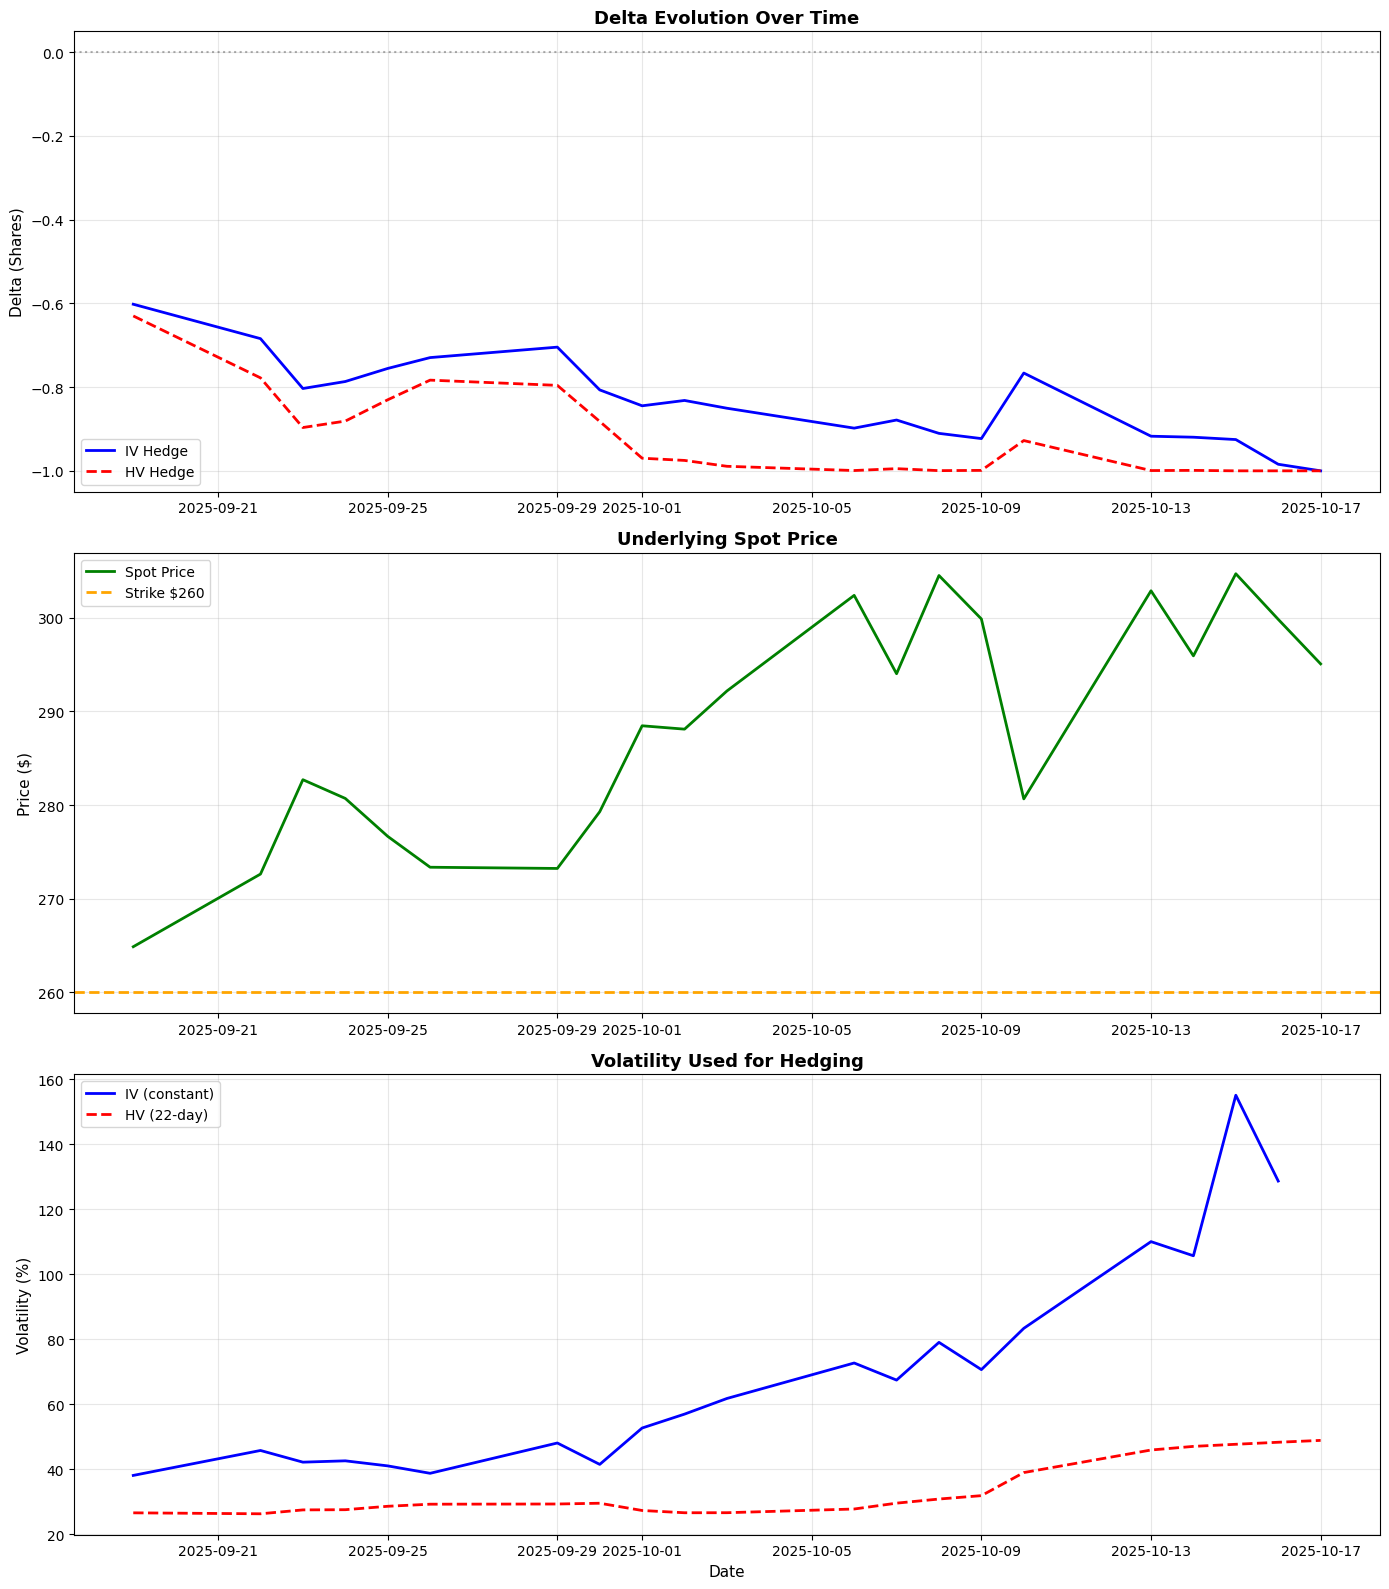

In [29]:
print("="*80)
print("PART 3: DELTA EVOLUTION - ATM CALL OPTION")
print("="*80)


def calculate_delta(S, K, T, r, sigma, option_type='call'):
    """Calculate Black-Scholes delta"""
    if T <= 0:
        if option_type == 'call':
            return 1.0 if S > K else 0.0
        else:
            return -1.0 if S < K else 0.0
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    if option_type == 'call':
        return norm.cdf(d1)
    else:
        return norm.cdf(d1) - 1

# ------------------------------
# Setup Parameters
# ------------------------------

# Trade and expiry dates
trade_date = pd.to_datetime('2025-09-19')
expiry_date = pd.to_datetime('2025-10-17')
trade_date_key = '19_Sep'

# Get spot price on trade date
spot_trade_date = options_data[trade_date_key]['spot']

# Get calls data
calls_trade = options_data[trade_date_key]['calls'].copy()

# Find ATM strike (closest to spot)
calls_trade['Strike_Diff'] = abs(calls_trade['Strike'] - spot_trade_date)
atm_strike = calls_trade.loc[calls_trade['Strike_Diff'].idxmin(), 'Strike']

print(f"\nSetup:")
print(f"  Trade Date: {trade_date.strftime('%Y-%m-%d')}")
print(f"  Expiry Date: {expiry_date.strftime('%Y-%m-%d')}")
print(f"  Days to Expiry: {(expiry_date - trade_date).days}")
print(f"  Spot on Trade Date: ${spot_trade_date:.2f}")
print(f"  ATM Strike: ${atm_strike}")
print(f"  Risk-free Rate: {r:.2%}")
print(f"  Dividend Yield: {q:.2%}")

# Get ATM call option data
atm_call = calls_trade[calls_trade['Strike'] == atm_strike].iloc[0]
option_premium = atm_call['Mid']
implied_vol = atm_call['IV']

print(f"\nATM Call Option:")
print(f"  Premium (Mid): ${option_premium:.2f}")
print(f"  Implied Volatility: {implied_vol:.2%}")

# Get daily prices for hedging period
closing_prices_copy = closing_prices.copy()
closing_prices_copy['Date'] = pd.to_datetime(closing_prices_copy['Date'])

hedging_data = closing_prices_copy[
    (closing_prices_copy['Date'] >= trade_date) & 
    (closing_prices_copy['Date'] <= expiry_date)
].copy()
hedging_data = hedging_data.sort_values('Date').reset_index(drop=True)

print(f"\nHedging Period:")
print(f"  Number of Days: {len(hedging_data)}")
print(f"  Initial Spot: ${hedging_data.iloc[0]['Last Price']:.2f}")
print(f"  Final Spot: ${hedging_data.iloc[-1]['Last Price']:.2f}")

# Get 22-day historical volatility on trade date
hv_22_trade = closing_prices_copy[
    closing_prices_copy['Date'] == trade_date
]['stdev_22_ln_annualized'].values[0]

print(f"\n22-Day Historical Volatility on Trade Date: {hv_22_trade:.2%}")

# ------------------------------
# Simulation Function
# ------------------------------

def daily_delta_calculation(spot_prices, dates, K, premium, r, q, vol_type='IV', options_data=None):
    """
    Perform daily delta calculation for hedging.
    
    Parameters:
    -----------
    spot_prices : pd.Series
        Daily spot prices
    dates : pd.Series
        Corresponding dates
    K : float
        Strike price
    premium : float
        Option premium received
    r : float
        Risk-free rate
    q : float
        Dividend yield
    vol_type : str
        'IV' for constant implied vol or 'HV' for historical vol
    sigma : float
        Constant volatility (if vol_type='IV')
    
    Returns:
    --------
    dict : Simulation results
    """
    
    results = {
        'date': [],
        'spot': [],
        'days_to_expiry': [],
        'volatility': [],
        'delta': []
    }
    
    # Initialize
    shares_held = 0
    cash = premium  # We receive premium upfront
    
    for i in range(len(dates)):
        date = dates.iloc[i]
        spot = spot_prices.iloc[i]
        
        # Time to expiry (in years)
        days_left = (expiry_date - date).days
        T = max(days_left / 365.0, 0)
        
        date_key = f"{date.day}_{date.strftime('%b')}"
        date_calls = options_data[date_key]['calls'].copy()
        call_option = date_calls[date_calls['Strike'] == K] 

        if call_option.empty:
            raise Exception(f'Option data not found for date {date_key}, strike: {K}')

        # Get volatility
        if vol_type == 'IV':
            if not ((pd.isna(call_option['IV'].values[0])) and (date_key != expiry_date.strftime('%d_%b'))):
                vol = call_option['IV'].values[0]
            else:
                # if date_key != expiry_date.strftime('%d_%b'):
                raise Exception(f'vol not found for date {date_key}, strike: {K}, expiry: {expiry_date.strftime('%d_%b')}') # Fallback to initial IV
        else:  # HV
            # Get HV for this date from closing_prices
            hv_row = closing_prices_copy[closing_prices_copy['Date'] == date]
            if not hv_row.empty and not pd.isna(hv_row['stdev_22_ln_annualized'].values[0]):
                vol = hv_row['stdev_22_ln_annualized'].values[0]
            else:
                vol = hv_22_trade  # Fallback
        
        # Calculate delta (negative because we're SHORT the call)
        if T > 0:
            delta = -calculate_delta(spot, K, T, r, vol, 'call')
        else:
            delta = -1.0 if spot > K else 0.0
        
        # Store results
        results['date'].append(date)
        results['spot'].append(spot)
        results['days_to_expiry'].append(days_left)
        results['volatility'].append(vol)
        results['delta'].append(delta)
    
    return {
        'df': pd.DataFrame(results)
    }


# ------------------------------
# Run Simulations
# ------------------------------

print("\n" + "="*80)
print("RESULT 1: Delta Calculations with IMPLIED VOLATILITY")
print("="*80)

sim_iv = daily_delta_calculation(
    spot_prices=hedging_data['Last Price'],
    dates=hedging_data['Date'],
    K=atm_strike,
    premium=option_premium,
    r=r,
    q=q,
    vol_type='IV',
    options_data=options_data
)

print(f"\nResults:")
print(sim_iv['df'])


print("\n" + "="*80)
print("RESULT 2: Delta Calculations with HISTORICAL VOLATILITY (22-day)")
print("="*80)

sim_hv = daily_delta_calculation(
    spot_prices=hedging_data['Last Price'],
    dates=hedging_data['Date'],
    K=atm_strike,
    premium=option_premium,
    r=r,
    q=q,
    vol_type='HV',
    options_data=options_data
)

print(f"\nResults:")
print(sim_hv['df'])

# ------------------------------
# Visualization
# ------------------------------

fig, axes = plt.subplots(3, 1, figsize=(14, 16))

# Plot 1: Delta evolution
ax1 = axes[0]
ax1.plot(sim_iv['df']['date'], sim_iv['df']['delta'], 'b-', linewidth=2, label='IV Hedge')
ax1.plot(sim_hv['df']['date'], sim_hv['df']['delta'], 'r--', linewidth=2, label='HV Hedge')
ax1.axhline(y=0, color='k', linestyle=':', alpha=0.3)
ax1.set_ylabel('Delta (Shares)', fontsize=11)
ax1.set_title('Delta Evolution Over Time', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 3: Spot price
ax3 = axes[1]
ax3.plot(sim_iv['df']['date'], sim_iv['df']['spot'], 'g-', linewidth=2, label='Spot Price')
ax3.axhline(y=atm_strike, color='orange', linestyle='--', linewidth=2, label=f'Strike ${atm_strike}')
ax3.set_ylabel('Price ($)', fontsize=11)
ax3.set_title('Underlying Spot Price', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Volatility comparison
ax4 = axes[2]
ax4.plot(sim_iv['df']['date'], sim_iv['df']['volatility'] * 100, 'b-', linewidth=2, label='IV (constant)')
ax4.plot(sim_hv['df']['date'], sim_hv['df']['volatility'] * 100, 'r--', linewidth=2, label='HV (22-day)')
ax4.set_ylabel('Volatility (%)', fontsize=11)
ax4.set_xlabel('Date', fontsize=11)
ax4.set_title('Volatility Used for Hedging', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part3_delta_hedging_complete.png', dpi=300, bbox_inches='tight')
plt.show()


# DELTA HEDGING

In [30]:
def calculate_delta(S, K, T, r, sigma, option_type='call', q=0):
    """Calculate Black-Scholes delta with dividend yield"""
    if T <= 0:
        if option_type == 'call':
            return 1.0 if S > K else 0.0
        else:
            return -1.0 if S < K else 0.0
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    if option_type == 'call':
        return np.exp(-q * T) * norm.cdf(d1)
    else:
        return np.exp(-q * T) * (norm.cdf(d1) - 1)


def delta_hedge_simulation(spot_prices, dates, K, premium, r, q, expiry_date, 
                           vol_type='IV', options_data=None, option_type='call',
                           position_size=1, closing_prices_copy=None, hv_22_trade=None):
    """
    Complete delta hedging simulation with:
    - Delta calculation using Black-Scholes
    - Real market option prices from options_data
    - Average cost tracking for underlying hedge
    - Realized and unrealized P&L
    - Value of underlying position
    
    Parameters:
    -----------
    spot_prices : list/array
        Daily spot prices (used if options_data not provided)
    dates : list
        Trading dates
    K : float
        Strike price
    premium : float
        Initial premium collected/paid per option
    r : float
        Risk-free rate (annualized)
    q : float
        Dividend yield (annualized)
    expiry_date : datetime
        Option expiry date
    vol_type : str
        'IV' for implied volatility or 'HV' for historical volatility
    options_data : dict
        Daily options data: {date_key: {'spot': float, 'calls': df, 'puts': df}}
    option_type : str
        'call' or 'put'
    position_size : float
        Number of options (negative for short position)
    closing_prices_copy : DataFrame
        Historical prices with HV data (if vol_type='HV')
    hv_22_trade : float
        Fallback HV value
    
    Returns:
    --------
    DataFrame with complete hedging tracking
    """
    
    results = []
    hedge_position = 0  # Shares of underlying held
    avg_cost_per_share = 0  # Weighted average cost
    cum_realized_pnl = 0  # Cumulative realized P&L from trading
    
    # Convert dates to datetime if needed
    if isinstance(dates[0], str):
        dates = [datetime.strptime(d, '%Y-%m-%d') if isinstance(d, str) else d for d in dates]
    if isinstance(expiry_date, str):
        expiry_date = datetime.strptime(expiry_date, '%Y-%m-%d')
    
    for i, date in enumerate(dates):
        date_key = f"{date.day}_{date.strftime('%b')}"
        
        # Get current spot price
        if options_data and date_key in options_data:
            S = options_data[date_key]['spot']
        else:
            S = spot_prices[i] if spot_prices is not None else None
            if S is None:
                raise Exception(f"No spot price data for {date_key}")
        
        # Calculate time to expiry
        T = max((expiry_date - date).days / 365.0, 0)
        
        # Get option data and volatility
        if options_data and date_key in options_data:
            if option_type == 'call':
                option_df = options_data[date_key]['calls']
            else:
                option_df = options_data[date_key]['puts']
            
            option_row = option_df[option_df['Strike'] == K]
            if option_row.empty:
                raise Exception(f'Strike {K} not found for {date_key}')
            
            # Get REAL market option price
            option_value = option_row['Mid'].values[0]
            
            # Get volatility based on vol_type
            if vol_type == 'IV':
                if not pd.isna(option_row['IV'].values[0]):
                    vol = option_row['IV'].values[0]
                elif date_key == expiry_date.strftime('%d_%b'):
                    vol = 0.01  # Minimal vol at expiry
                else:
                    raise Exception(f'IV not found for date {date_key}, strike {K}')
            else:  # HV
                if closing_prices_copy is not None:
                    hv_row = closing_prices_copy[closing_prices_copy['Date'] == date]
                    if not hv_row.empty and not pd.isna(hv_row['stdev_22_ln_annualized'].values[0]):
                        vol = hv_row['stdev_22_ln_annualized'].values[0]
                    else:
                        vol = hv_22_trade
                else:
                    raise Exception("closing_prices_copy required for HV calculation")
        else:
            raise Exception(f"options_data required for date {date_key}")
        
        # Calculate delta using Black-Scholes
        # print(f"Calculating delta for {date_key}: S={S}, K={K}, T={T:.4f}, r={r}, vol={vol:.4f}")
        current_delta = calculate_delta(S, K, T, r, vol, option_type, q)
        position_delta = current_delta * position_size
        
        # Calculate required hedge (OPPOSITE sign to neutralize)
        required_hedge = -position_delta
        delta_change = current_delta - results[-1]['Delta'] if i > 0 else current_delta
        shares_traded = required_hedge - hedge_position
        
        # TRADING LOGIC with Average Cost Tracking
        if shares_traded > 0:  # BUYING shares
            # Update weighted average cost
            total_cost = (hedge_position * avg_cost_per_share) + (shares_traded * S)
            hedge_position = required_hedge
            avg_cost_per_share = total_cost / hedge_position if hedge_position != 0 else 0
            
            cash_flow = shares_traded * S  # Cash OUT (positive = spent)
            realized_pnl_today = 0  # No realized P&L when buying
            
        elif shares_traded < 0:  # SELLING shares
            shares_sold = abs(shares_traded)
            
            # Realized P&L = (Sale Price - Average Cost) × Shares Sold
            realized_pnl_today = shares_sold * (S - avg_cost_per_share)
            cum_realized_pnl += realized_pnl_today
            
            cash_flow = shares_sold * S  # Cash IN (positive = received)
            hedge_position = required_hedge
            # Average cost stays same for remaining shares
            
        else:  # No trade
            cash_flow = 0
            realized_pnl_today = 0
        
        # Calculate Value of Underlying (current market value of hedge position)
        value_of_underlying = hedge_position * S
        
        # Calculate Unrealized P&L (mark-to-market on current holdings)
        unrealized_pnl = hedge_position * (S - avg_cost_per_share) if hedge_position != 0 else 0
        
        # Store results
        results.append({
            'Date': date,
            'Days_to_Expiry': T * 365,
            'Spot_Price': S,
            'Volatility': vol,
            'Option_Value': option_value,
            'Delta': current_delta,
            'Position_Delta': position_delta,
            'Delta_Change': delta_change,
            'Required_Hedge': required_hedge,
            'Hedge_Position': hedge_position,
            'Shares_Traded': shares_traded,
            'Trade_Price': S,
            'Avg_Cost_per_Share': avg_cost_per_share,
            'Value_of_Underlying': value_of_underlying,
            'Cash_Flow': cash_flow,
            'Realized_PnL_Today': realized_pnl_today,
            'Unrealized_PnL': unrealized_pnl,
            'Cum_Realized_PnL': cum_realized_pnl
        })
    
    results_df = pd.DataFrame(results)
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"DELTA HEDGE SIMULATION SUMMARY")
    print(f"{'='*80}")
    print(f"Option Type: {option_type.upper()}")
    print(f"Strike: ${K:.2f}")
    print(f"Position Size: {position_size} contracts")
    print(f"Initial Premium: ${premium * position_size:.2f}")
    print(f"\nFINAL RESULTS:")
    print(f"  Final Hedge Position: {results_df.iloc[-1]['Hedge_Position']:.4f} shares")
    print(f"  Final Value of Underlying: ${results_df.iloc[-1]['Value_of_Underlying']:.2f}")
    print(f"  Average Cost per Share: ${results_df.iloc[-1]['Avg_Cost_per_Share']:.2f}")
    print(f"  Cumulative Realized P&L: ${results_df.iloc[-1]['Cum_Realized_PnL']:.2f}")
    print(f"  Unrealized P&L: ${results_df.iloc[-1]['Unrealized_PnL']:.2f}")
    print(f"  Total Trading Cashflow: ${results_df['Cash_Flow'].sum():.2f}")
    print('Conciled P&L Check:')
    print(f"{premium-results_df.iloc[-1]['Option_Value'] + (results_df.iloc[-1]['Cum_Realized_PnL'] + results_df.iloc[-1]['Unrealized_PnL'])}")
    print(f"{'='*80}\n")
    
    return results_df

In [31]:
result_iv = delta_hedge_simulation(spot_prices=hedging_data['Last Price'],
    dates=hedging_data['Date'],
    K=atm_strike,
    premium=option_premium,
    r=r,
    q=q,
    expiry_date=expiry_date,
    vol_type='IV',
    options_data=options_data,
    option_type='call',
    position_size=-1,
    closing_prices_copy=closing_prices_copy,
    hv_22_trade=hv_22_trade)

result_iv


DELTA HEDGE SIMULATION SUMMARY
Option Type: CALL
Strike: $260.00
Position Size: -1 contracts
Initial Premium: $-13.95

FINAL RESULTS:
  Final Hedge Position: 1.0000 shares
  Final Value of Underlying: $295.08
  Average Cost per Share: $280.63
  Cumulative Realized P&L: $2.36
  Unrealized P&L: $14.45
  Total Trading Cashflow: $439.30
Conciled P&L Check:
-5.909930161580295



,Date,Days_to_Expiry,Spot_Price,Volatility,Option_Value,Delta,Position_Delta,Delta_Change,Required_Hedge,Hedge_Position,Shares_Traded,Trade_Price,Avg_Cost_per_Share,Value_of_Underlying,Cash_Flow,Realized_PnL_Today,Unrealized_PnL,Cum_Realized_PnL
0,2025-09-19,28.0,264.87,0.380826,13.950000,0.598066,-0.598066,0.598066,0.598066,0.598066,0.598066,264.87,264.870000,158.409711,158.409711,0.000000,0.000000,0.000000
1,2025-09-22,25.0,272.63,0.457595,20.324997,0.681171,-0.681171,0.083106,0.681171,0.681171,0.083106,272.63,265.816750,185.707772,22.657070,0.000000,4.640991,0.000000
2,2025-09-23,24.0,282.71,0.421624,26.750000,0.800659,-0.800659,0.119488,0.800659,0.800659,0.119488,282.71,268.337844,226.354373,33.780393,0.000000,11.507199,0.000000
3,2025-09-24,23.0,280.71,0.425723,25.050003,0.783968,-0.783968,-0.016691,0.783968,0.783968,-0.016691,280.71,268.337844,220.067587,4.685468,0.206510,9.699371,0.206510
4,2025-09-25,22.0,276.66,0.410181,21.400002,0.752611,-0.752611,-0.031357,0.752611,0.752611,-0.031357,276.66,268.337844,208.217317,8.675200,0.260957,6.263345,0.467467
5,2025-09-26,21.0,273.36,0.387331,18.250000,0.726494,-0.726494,-0.026117,0.726494,0.726494,-0.026117,273.36,268.337844,198.594275,7.139426,0.131165,3.648564,0.598632
6,2025-09-29,18.0,273.23,0.480608,19.400002,0.702151,-0.702151,-0.024342,0.702151,0.702151,-0.024342,273.23,268.337844,191.848747,6.651084,0.119087,3.435033,0.717719
7,2025-09-30,17.0,279.29,0.414750,22.450005,0.804497,-0.804497,0.102345,0.804497,0.804497,0.102345,279.29,269.731142,224.687852,28.584069,0.000000,7.690068,0.717719
8,2025-10-01,16.0,288.47,0.526714,31.525002,0.843050,-0.843050,0.038553,0.843050,0.843050,0.038553,288.47,270.588076,243.194490,11.121359,0.000000,15.075347,0.717719
9,2025-10-02,15.0,288.11,0.569499,31.574997,0.830376,-0.830376,-0.012673,0.830376,0.830376,-0.012673,288.11,270.588076,239.239636,3.651356,0.222064,14.549786,0.939783


In [32]:
result_hv = delta_hedge_simulation(spot_prices=hedging_data['Last Price'],
    dates=hedging_data['Date'],
    K=atm_strike,
    premium=option_premium,
    r=r,
    q=q,
    expiry_date=expiry_date,
    vol_type='HV',
    options_data=options_data,
    option_type='call',
    position_size=-1,
    closing_prices_copy=closing_prices_copy,
    hv_22_trade=hv_22_trade)

result_hv


DELTA HEDGE SIMULATION SUMMARY
Option Type: CALL
Strike: $260.00
Position Size: -1 contracts
Initial Premium: $-13.95

FINAL RESULTS:
  Final Hedge Position: 1.0000 shares
  Final Value of Underlying: $295.08
  Average Cost per Share: $274.54
  Cumulative Realized P&L: $1.55
  Unrealized P&L: $20.54
  Total Trading Cashflow: $379.37
Conciled P&L Check:
-0.6262993569520603



,Date,Days_to_Expiry,Spot_Price,Volatility,Option_Value,Delta,Position_Delta,Delta_Change,Required_Hedge,Hedge_Position,Shares_Traded,Trade_Price,Avg_Cost_per_Share,Value_of_Underlying,Cash_Flow,Realized_PnL_Today,Unrealized_PnL,Cum_Realized_PnL
0,2025-09-19,28.0,264.87,0.265688,13.950000,0.624640,-0.624640,0.624640,0.624640,0.624640,0.624640,264.87,264.870000,165.448423,165.448423,0.000000,0.000000,0.000000
1,2025-09-22,25.0,272.63,0.262730,20.324997,0.773675,-0.773675,0.149034,0.773675,0.773675,0.149034,272.63,266.364824,210.926890,40.631260,0.000000,4.847207,0.000000
2,2025-09-23,24.0,282.71,0.274716,26.750000,0.893834,-0.893834,0.120160,0.893834,0.893834,0.120160,282.71,268.562136,252.695908,33.970378,0.000000,12.645847,0.000000
3,2025-09-24,23.0,280.71,0.275329,25.050003,0.878313,-0.878313,-0.015521,0.878313,0.878313,-0.015521,280.71,268.562136,246.551217,4.357023,0.188552,10.669626,0.188552
4,2025-09-25,22.0,276.66,0.285856,21.400002,0.827066,-0.827066,-0.051247,0.827066,0.827066,-0.051247,276.66,268.562136,228.815997,14.178052,0.414993,6.697465,0.603545
5,2025-09-26,21.0,273.36,0.292271,18.250000,0.779880,-0.779880,-0.047186,0.779880,0.779880,-0.047186,273.36,268.562136,213.188028,12.898653,0.226390,3.741759,0.829935
6,2025-09-29,18.0,273.23,0.292874,19.400002,0.792746,-0.792746,0.012866,0.792746,0.792746,0.012866,273.23,268.637895,216.602086,3.515443,0.000000,3.640374,0.829935
7,2025-09-30,17.0,279.29,0.295236,22.450005,0.879773,-0.879773,0.087027,0.879773,0.879773,0.087027,279.29,269.691596,245.711802,24.305673,0.000000,8.444417,0.829935
8,2025-10-01,16.0,288.47,0.272896,31.525002,0.968710,-0.968710,0.088937,0.968710,0.968710,0.088937,288.47,271.415633,279.443721,25.655603,0.000000,16.520733,0.829935
9,2025-10-02,15.0,288.11,0.265934,31.574997,0.974130,-0.974130,0.005420,0.974130,0.974130,0.005420,288.11,271.508524,280.656619,1.561633,0.000000,16.171998,0.829935




PART 4: VOLATILITY TRADING STRATEGY

Volatility Analysis on 2025-09-19:
  22-Day Historical Volatility: 26.57%
  ATM Implied Volatility: 38.08%
  IV - HV Spread: 11.51%

  → IV > HV: Options are EXPENSIVE
  → Strategy: SELL VOLATILITY (Short Straddle)

Straddle at Strike $260:
  Call Premium: $13.95 (IV: 38.08%)
  Put Premium: $8.18 (IV: 36.91%)
  Total Premium: $22.13

  Cash Received (selling both): $22.13

--------------------------------------------------------------------------------
ACTUAL OUTCOME AT EXPIRY
--------------------------------------------------------------------------------
Final Spot Price: $295.08
Call Payoff: $-35.08
Put Payoff: $0.00
Total P&L: $-12.95
Status: LOSS ✗

Breakeven Points:
  Upper: $282.13
  Lower: $237.87

--------------------------------------------------------------------------------
COST COMPARISON: CALLS vs PUTS
--------------------------------------------------------------------------------
Average Call IV: 99.74%
Average Put IV: 82.98%
Call-

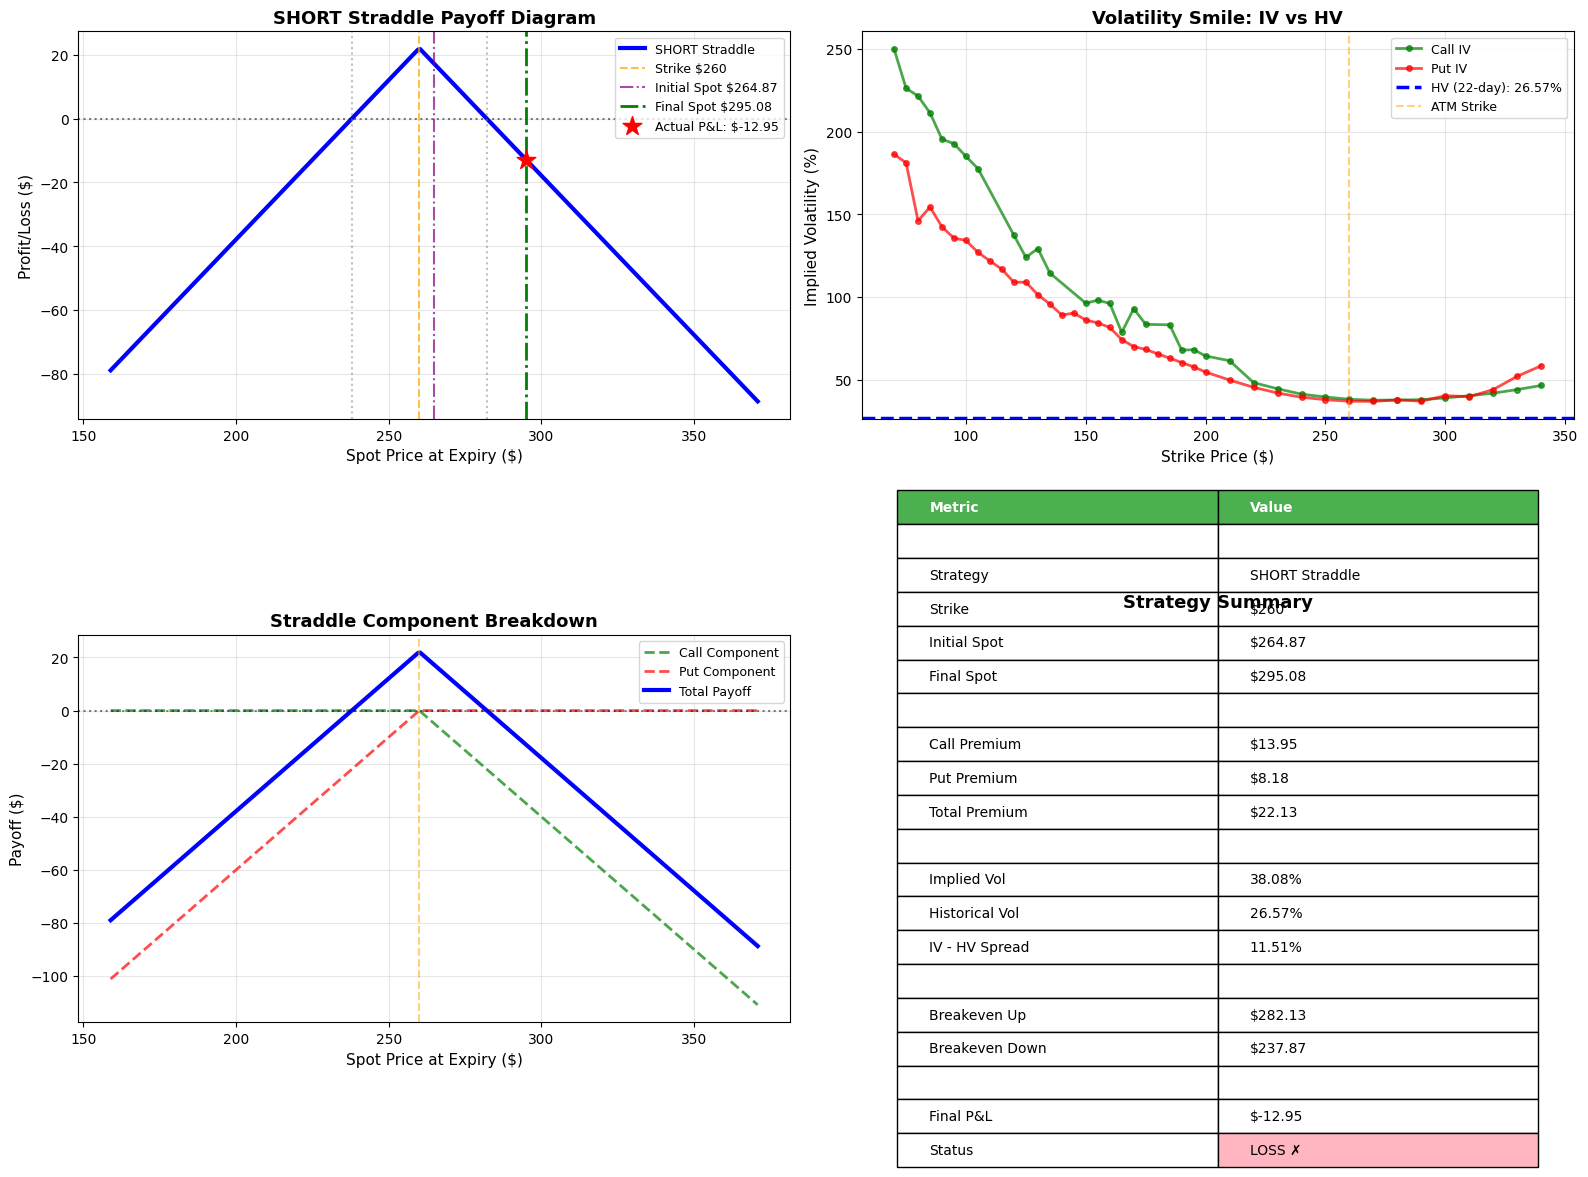


✓ Part 4 complete and saved!

Volatility Trade Results:
  Strategy: SHORT Straddle at $260
  Premium Collected/Paid:        $     22.13
  Final P&L:                     $    -12.95
  Status: LOSS ✗
  Call-Put Price Diff:           $      5.78

✓ ALL CALCULATIONS COMPLETE!
✓ Visualizations saved:
   - part3_delta_hedging_complete.png
   - part4_volatility_trade_complete.png


In [33]:

# ============================================================================
# PART 4: VOLATILITY TRADING STRATEGY
# ============================================================================

print("\n\n" + "="*80)
print("PART 4: VOLATILITY TRADING STRATEGY")
print("="*80)

# Get trade date options
calls_trade_p4 = options_data[trade_date_key]['calls'].copy()
puts_trade_p4 = options_data[trade_date_key]['puts'].copy()

print(f"\nVolatility Analysis on {trade_date.strftime('%Y-%m-%d')}:")
print(f"  22-Day Historical Volatility: {hv_22_trade:.2%}")
print(f"  ATM Implied Volatility: {implied_vol:.2%}")
print(f"  IV - HV Spread: {(implied_vol - hv_22_trade):.2%}")

if implied_vol > hv_22_trade:
    print(f"\n  → IV > HV: Options are EXPENSIVE")
    print(f"  → Strategy: SELL VOLATILITY (Short Straddle)")
    trade_type = "SHORT"
else:
    print(f"\n  → IV < HV: Options are CHEAP")
    print(f"  → Strategy: BUY VOLATILITY (Long Straddle)")
    trade_type = "LONG"

# Get ATM call and put
atm_call_data = calls_trade_p4[calls_trade_p4['Strike'] == atm_strike].iloc[0]
atm_put_data = puts_trade_p4[puts_trade_p4['Strike'] == atm_strike].iloc[0]

call_premium = atm_call_data['Mid']
put_premium = atm_put_data['Mid']
total_premium = call_premium + put_premium

print(f"\nStraddle at Strike ${atm_strike}:")
print(f"  Call Premium: ${call_premium:.2f} (IV: {atm_call_data['IV']:.2%})")
print(f"  Put Premium: ${put_premium:.2f} (IV: {atm_put_data['IV']:.2%})")
print(f"  Total Premium: ${total_premium:.2f}")

if trade_type == "SHORT":
    print(f"\n  Cash Received (selling both): ${total_premium:.2f}")
else:
    print(f"\n  Cash Paid (buying both): ${total_premium:.2f}")

# Create payoff diagram
spot_range = np.linspace(spot_trade_date * 0.6, spot_trade_date * 1.4, 300)

if trade_type == "SHORT":
    payoff = []
    for S in spot_range:
        call_payoff = -max(S - atm_strike, 0)
        put_payoff = -max(atm_strike - S, 0)
        total_payoff = call_payoff + put_payoff + total_premium
        payoff.append(total_payoff)
else:
    payoff = []
    for S in spot_range:
        call_payoff = max(S - atm_strike, 0)
        put_payoff = max(atm_strike - S, 0)
        total_payoff = call_payoff + put_payoff - total_premium
        payoff.append(total_payoff)

# Calculate actual payoff at expiry
final_spot = hedging_data.iloc[-1]['Last Price']

if trade_type == "SHORT":
    final_call_payoff = -max(final_spot - atm_strike, 0)
    final_put_payoff = -max(atm_strike - final_spot, 0)
    final_total = final_call_payoff + final_put_payoff + total_premium
else:
    final_call_payoff = max(final_spot - atm_strike, 0)
    final_put_payoff = max(atm_strike - final_spot, 0)
    final_total = final_call_payoff + final_put_payoff - total_premium

print(f"\n" + "-"*80)
print(f"ACTUAL OUTCOME AT EXPIRY")
print("-"*80)
print(f"Final Spot Price: ${final_spot:.2f}")
print(f"Call Payoff: ${final_call_payoff:.2f}")
print(f"Put Payoff: ${final_put_payoff:.2f}")
print(f"Total P&L: ${final_total:.2f}")
print(f"Status: {'PROFIT ✓' if final_total > 0 else 'LOSS ✗'}")

# Breakeven points
be_up = atm_strike + total_premium
be_down = atm_strike - total_premium
print(f"\nBreakeven Points:")
print(f"  Upper: ${be_up:.2f}")
print(f"  Lower: ${be_down:.2f}")

# Cost comparison
calls_clean = calls_trade_p4.dropna(subset=['IV'])
puts_clean = puts_trade_p4.dropna(subset=['IV'])

avg_call_iv = calls_clean['IV'].mean()
avg_put_iv = puts_clean['IV'].mean()

print(f"\n" + "-"*80)
print("COST COMPARISON: CALLS vs PUTS")
print("-"*80)
print(f"Average Call IV: {avg_call_iv:.2%}")
print(f"Average Put IV: {avg_put_iv:.2%}")
print(f"Call-Put IV Spread: {(avg_call_iv - avg_put_iv):.2%}")

if call_premium > put_premium:
    print(f"\nCALLS are more expensive by ${call_premium - put_premium:.2f}")
    print(f"Reason: Likely skew effect - calls priced higher due to upside demand")
else:
    print(f"\nPUTS are more expensive by ${put_premium - call_premium:.2f}")
    print(f"Reason: Likely skew effect - puts priced higher due to downside protection demand")

# ------------------------------
# Visualization - Part 4
# ------------------------------

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Payoff Diagram
ax1 = axes[0, 0]
ax1.plot(spot_range, payoff, 'b-', linewidth=3, label=f'{trade_type} Straddle')
ax1.axhline(y=0, color='k', linestyle=':', alpha=0.5)
ax1.axvline(x=atm_strike, color='orange', linestyle='--', alpha=0.7, label=f'Strike ${atm_strike}')
ax1.axvline(x=spot_trade_date, color='purple', linestyle='-.', alpha=0.7, label=f'Initial Spot ${spot_trade_date:.2f}')
ax1.axvline(x=final_spot, color='green', linestyle='-.', linewidth=2, label=f'Final Spot ${final_spot:.2f}')
ax1.scatter([final_spot], [final_total], color='red', s=200, zorder=5, marker='*', 
            label=f'Actual P&L: ${final_total:.2f}')
ax1.axvline(x=be_up, color='gray', linestyle=':', alpha=0.5)
ax1.axvline(x=be_down, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Spot Price at Expiry ($)', fontsize=11)
ax1.set_ylabel('Profit/Loss ($)', fontsize=11)
ax1.set_title(f'{trade_type} Straddle Payoff Diagram', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9, loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: IV Smile
ax2 = axes[0, 1]
ax2.plot(calls_clean['Strike'], calls_clean['IV'] * 100, 'go-', linewidth=2, 
         markersize=4, label='Call IV', alpha=0.7)
ax2.plot(puts_clean['Strike'], puts_clean['IV'] * 100, 'ro-', linewidth=2, 
         markersize=4, label='Put IV', alpha=0.7)
ax2.axhline(y=hv_22_trade * 100, color='blue', linestyle='--', linewidth=2.5, 
            label=f'HV (22-day): {hv_22_trade:.2%}')
ax2.axvline(x=atm_strike, color='orange', linestyle='--', alpha=0.5, label='ATM Strike')
ax2.set_xlabel('Strike Price ($)', fontsize=11)
ax2.set_ylabel('Implied Volatility (%)', fontsize=11)
ax2.set_title('Volatility Smile: IV vs HV', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Component Payoffs
ax3 = axes[1, 0]
if trade_type == "SHORT":
    call_component = [-max(S - atm_strike, 0) for S in spot_range]
    put_component = [-max(atm_strike - S, 0) for S in spot_range]
else:
    call_component = [max(S - atm_strike, 0) for S in spot_range]
    put_component = [max(atm_strike - S, 0) for S in spot_range]

ax3.plot(spot_range, call_component, 'g--', linewidth=2, label='Call Component', alpha=0.7)
ax3.plot(spot_range, put_component, 'r--', linewidth=2, label='Put Component', alpha=0.7)
ax3.plot(spot_range, payoff, 'b-', linewidth=3, label='Total Payoff')
ax3.axhline(y=0, color='k', linestyle=':', alpha=0.5)
ax3.axvline(x=atm_strike, color='orange', linestyle='--', alpha=0.5)
ax3.set_xlabel('Spot Price at Expiry ($)', fontsize=11)
ax3.set_ylabel('Payoff ($)', fontsize=11)
ax3.set_title('Straddle Component Breakdown', fontsize=13, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: Summary Table
ax4 = axes[1, 1]
ax4.axis('off')

summary_data = [
    ['Metric', 'Value'],
    ['', ''],
    ['Strategy', f'{trade_type} Straddle'],
    ['Strike', f'${atm_strike}'],
    ['Initial Spot', f'${spot_trade_date:.2f}'],
    ['Final Spot', f'${final_spot:.2f}'],
    ['', ''],
    ['Call Premium', f'${call_premium:.2f}'],
    ['Put Premium', f'${put_premium:.2f}'],
    ['Total Premium', f'${total_premium:.2f}'],
    ['', ''],
    ['Implied Vol', f'{implied_vol:.2%}'],
    ['Historical Vol', f'{hv_22_trade:.2%}'],
    ['IV - HV Spread', f'{(implied_vol - hv_22_trade):.2%}'],
    ['', ''],
    ['Breakeven Up', f'${be_up:.2f}'],
    ['Breakeven Down', f'${be_down:.2f}'],
    ['', ''],
    ['Final P&L', f'${final_total:.2f}'],
    ['Status', 'PROFIT ✓' if final_total > 0 else 'LOSS ✗'],
]

table = ax4.table(cellText=summary_data, cellLoc='left', loc='center',
                  colWidths=[0.45, 0.45])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)

# Style the header
for i in range(2):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style profit/loss row
if final_total > 0:
    table[(len(summary_data)-1, 1)].set_facecolor('#90EE90')
else:
    table[(len(summary_data)-1, 1)].set_facecolor('#FFB6C1')

ax4.set_title('Strategy Summary', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('part4_volatility_trade_complete.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Part 4 complete and saved!")

# ============================================================================
# FINAL SUMMARY
# ============================================================================


print(f"\nVolatility Trade Results:")
print(f"  Strategy: {trade_type} Straddle at ${atm_strike}")
print(f"  {'Premium Collected/Paid:':<30} ${total_premium:>10.2f}")
print(f"  {'Final P&L:':<30} ${final_total:>10.2f}")
print(f"  Status: {'PROFITABLE ✓' if final_total > 0 else 'LOSS ✗'}")
print(f"  {'Call-Put Price Diff:':<30} ${abs(call_premium - put_premium):>10.2f}")

print("\n" + "="*80)
print("✓ ALL CALCULATIONS COMPLETE!")
print("✓ Visualizations saved:")
print("   - part3_delta_hedging_complete.png")
print("   - part4_volatility_trade_complete.png")
print("="*80)